In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
import warnings
warnings.filterwarnings("ignore")

# Machine learning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc as auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, accuracy_score, mean_squared_error, r2_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
plt.style.use('seaborn-v0_8')


In [7]:
os.chdir(r"C:\Users\Caxton Henry\.vscode\Anti-Money-Laundering-detection-and-Analysis-pipeline")

In [8]:
# Load the processed parquet samples
alerts = pd.read_parquet("data/processed/synthetic_alerts_sample.parquet")
transactions = pd.read_parquet("data/processed/synthetic_transactions_sample.parquet")

print(f"Alerts dataset shape: {alerts.shape}")
print(f"Transactions dataset shape: {transactions.shape}")

Alerts dataset shape: (20000, 3)
Transactions dataset shape: (100000, 5)


In [9]:
# Merge transactions and alerts by AlertID
merged = transactions.merge(alerts, on="AlertID", how="inner")
print(f"Merged dataset shape: {merged.shape}")

Merged dataset shape: (100000, 7)


In [10]:
# Convert text labels to binary format (for ML tasks)
merged['Label'] = merged['Outcome'].map({'Report': 1, 'Dismiss': 0})

In [13]:
#Base time features
merged['Timestamp'] = pd.to_datetime(merged['Timestamp'], errors='coerce')
merged['Hour'] = merged['Timestamp'].dt.hour
merged['Day'] = merged['Timestamp'].dt.day
merged['Month'] = merged['Timestamp'].dt.month
merged['Year'] = merged['Timestamp'].dt.year
merged['DayOfWeek'] = merged['Timestamp'].dt.dayofweek
merged['IsWeekend'] = (merged['DayOfWeek'] >= 5).astype(int)

In [14]:
#Transaction-level features
merged['AbsSize'] = merged['Size'].abs()
merged['LogSize'] = np.log1p(merged['AbsSize'])
merged['IsLargeTransaction'] = (merged['AbsSize'] > merged['AbsSize'].median()).astype(int)
merged['TransactionDensity'] = merged.groupby('AlertID')['Size'].transform('count')

#Encode categorical columns
merged = pd.get_dummies(merged, columns=['Entry', 'Type'], drop_first=True)

In [15]:
merged['Entry_Type_Interaction'] = (
    merged.get('Entry_Debit', 0) * merged.get('Type_Wire', 0)
)

agg_features = merged.groupby('AlertID').agg({
    'AbsSize': ['mean', 'max', 'min', 'std'],
    'IsLargeTransaction': 'sum',
    'TransactionDensity': 'mean'
})
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns]
merged = merged.merge(agg_features, on='AlertID', how='left')

print("\nFeature Engineering Complete.")
print(f"Final dataset shape: {merged.shape}")
print("Sample columns:", merged.columns.tolist()[:15])



Feature Engineering Complete.
Final dataset shape: (100000, 27)
Sample columns: ['AlertID', 'Timestamp', 'Size', 'Date', 'Outcome', 'Label', 'Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'AbsSize', 'LogSize', 'IsLargeTransaction']


In [17]:
merged.columns.tolist()


['AlertID',
 'Timestamp',
 'Size',
 'Date',
 'Outcome',
 'Label',
 'Hour',
 'Day',
 'Month',
 'Year',
 'DayOfWeek',
 'IsWeekend',
 'AbsSize',
 'LogSize',
 'IsLargeTransaction',
 'TransactionDensity',
 'Entry_Debit',
 'Type_Cash',
 'Type_International',
 'Type_Wire',
 'Entry_Type_Interaction',
 'AbsSize_mean',
 'AbsSize_max',
 'AbsSize_min',
 'AbsSize_std',
 'IsLargeTransaction_sum',
 'TransactionDensity_mean']

In [18]:
#Enhanced Alert-Level Aggregation Features
# Statistical aggregations per AlertID
agg = merged.groupby("AlertID").agg(
    AbsSize_mean=("AbsSize", "mean"),
    AbsSize_median=("AbsSize", "median"),
    AbsSize_std=("AbsSize", "std"),
    AbsSize_min=("AbsSize", "min"),
    AbsSize_max=("AbsSize", "max"),
    AbsSize_range=("AbsSize", lambda x: x.max() - x.min()),
    AbsSize_skew=("AbsSize", "skew"),
    
    LogSize_mean=("LogSize", "mean"),
    LogSize_std=("LogSize", "std"),

    TotalTxnCount=("Size", "count"),
    LargeTxnCount=("IsLargeTransaction", "sum"),
    
    # Ratio features
    LargeTxnRatio=("IsLargeTransaction", lambda x: x.sum() / len(x)),

    # Time-based burstiness
    Hour_std=("Hour", "std"),
    DayOfWeek_std=("DayOfWeek", "std"),
)

# Fix any NaN std values (e.g., alerts with 1 transaction)
agg = agg.fillna(0)

# Merge back into main DataFrame
merged = merged.merge(agg, on="AlertID", how="left")

print("complete: Enhanced Alert-level aggregation features added.")
print(f"Current shape: {merged.shape}")


complete: Enhanced Alert-level aggregation features added.
Current shape: (100000, 41)


In [21]:
#Typology & Domain-Specific Flags
#Round-number transactions
merged['IsRoundAmount'] = (merged['AbsSize'] % 100 == 0).astype(int)

#Threshold-proximity transactions
# Flag transactions just below 10,000 (typical reporting threshold)
threshold = 10000
merged['JustBelowThreshold'] = ((merged['AbsSize'] >= (threshold*0.9)) & (merged['AbsSize'] < threshold)).astype(int)

#Credit vs. Debit ratio per alert
if 'Entry_Debit' in merged.columns and 'Entry_Credit' in merged.columns:
    merged['Alert_CreditRatio'] = merged.groupby('AlertID')['Entry_Credit'].transform('sum') / (
        merged.groupby('AlertID')['Entry_Credit'].transform('sum') +
        merged.groupby('AlertID')['Entry_Debit'].transform('sum') + 1e-6
    )
else:
    merged['Alert_CreditRatio'] = 0

#Wire transfer / cash indicators (if one-hot encoded columns exist)
for col in ['Type_Wire', 'Type_Cash']:
    if col in merged.columns:
        merged[f'Alert_{col}_Count'] = merged.groupby('AlertID')[col].transform('sum')

#Alert concentration of large transactions
merged['Alert_LargeTxnRatio'] = merged.groupby('AlertID')['IsLargeTransaction'].transform(lambda x: x.sum()/len(x))

#Fill NaNs and infinities
merged = merged.fillna(0)
merged = merged.replace([np.inf, -np.inf], 0)

print("complete: Typology and domain-specific flags added.")
print(f"Current dataset shape: {merged.shape}")


complete: Typology and domain-specific flags added.
Current dataset shape: (100000, 47)


In [22]:
#Final Feature Selection & ML Preparation
#Define target column
target_col = 'Label'

#Drop identifiers / columns not needed for ML
drop_cols = ['AlertID', 'Timestamp', 'Date', 'Outcome', target_col]
merged_ml = merged.drop(columns=[col for col in drop_cols if col in merged.columns], errors='ignore')

#Select numeric features only (for most ML models)
X = merged_ml.select_dtypes(include=['number'])
y = merged[target_col]

print(f"Features selected for ML: {X.shape[1]} columns")
print("Sample feature names:", X.columns.tolist()[:10])

#Train-test split (stratified to preserve label balance)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Optional scaling (for models like LinearRegression or XGBoost)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("complete: Dataset ready for ML model training.")


Features selected for ML: 37 columns
Sample feature names: ['Size', 'Hour', 'Day', 'Month', 'Year', 'DayOfWeek', 'IsWeekend', 'AbsSize', 'LogSize', 'IsLargeTransaction']
Train samples: 80000, Test samples: 20000
complete: Dataset ready for ML model training.


In [24]:
#save prepared dataset to disk
import os
os.makedirs("data/processed", exist_ok=True)
X_train.to_parquet("data/processed/X_train_features.parquet", index=False)
X_test.to_parquet("data/processed/X_test_features.parquet", index=False)
y_train.to_frame().to_parquet("data/processed/y_train.parquet", index=False)
y_test.to_frame().to_parquet("data/processed/y_test.parquet", index=False)

print("Prepared datasets exported to 'data/processed/'")


Prepared datasets exported to 'data/processed/'


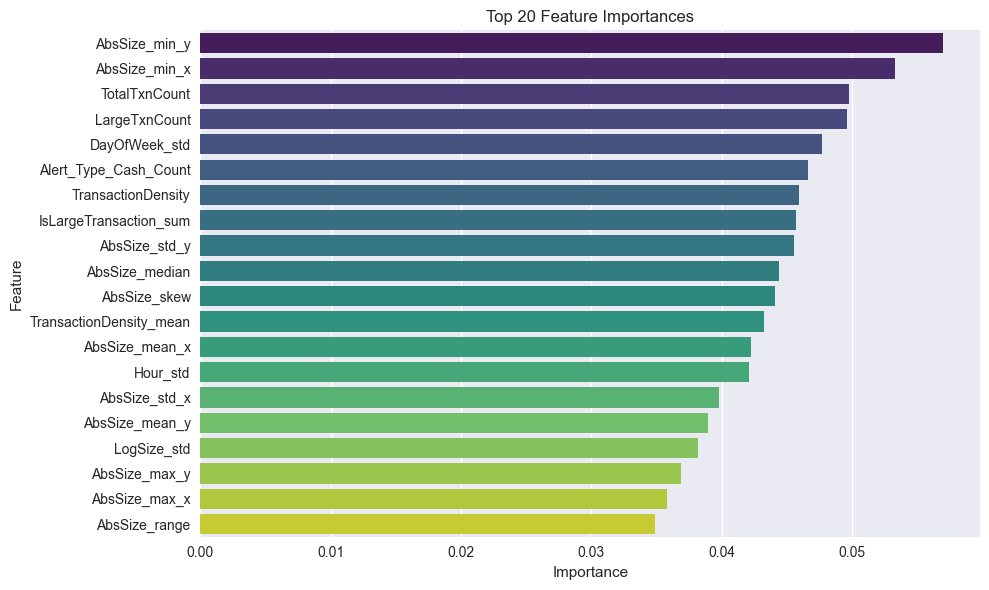

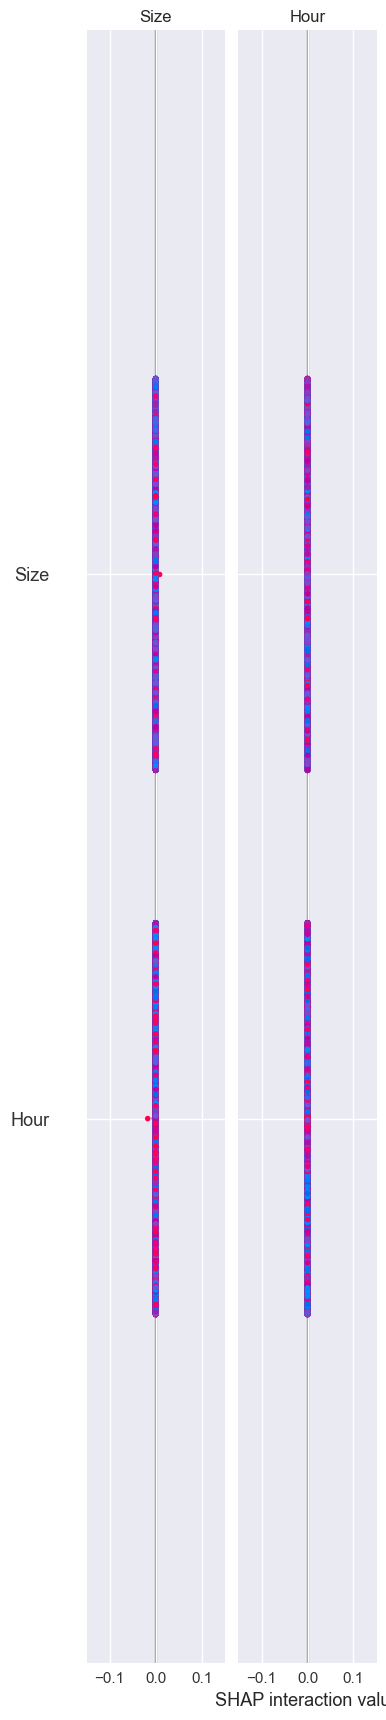

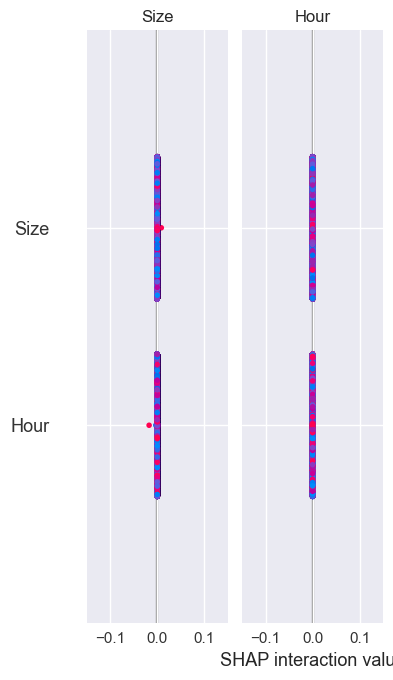

Cell complete: Feature importance and SHAP analysis generated.


In [ ]:
#Feature Importance & SHAP (for Random Forest or XGBoost)
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Choose model: rf_model or xgb_model
model_to_explain = rf_model  # replace with xgb_model if needed

# Use unscaled X_train DataFrame (for SHAP feature names)
X_train_df = X_train.copy()  

#TRAIN
# Only train if model not already fitted
if not hasattr(model_to_explain, "feature_importances_"):
    model_to_explain.fit(X_train, y_train)

#Feature Importances 
importances = model_to_explain.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": X_train_df.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(20), palette="viridis")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

#SHAP ANALYSIS 
explainer = shap.TreeExplainer(model_to_explain)
shap_values = explainer.shap_values(X_train_df)

# For binary classification: use positive class
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

# Summary plot (bar)
shap.summary_plot(shap_values_pos, X_train_df, plot_type="bar", max_display=20)

# Beeswarm plot (impact on predictions)
shap.summary_plot(shap_values_pos, X_train_df, plot_type="dot")

print("Cell complete: Feature importance and SHAP analysis generated.")


In [ ]:
#Threshold Tuning & Model Calibration

from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Use trained Random Forest or XGBoost model
model_to_tune = rf_model  # or xgb_model if trained
y_probs = model_to_tune.predict_proba(X_test)[:,1]


#Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Find threshold with highest F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold for max F1: {best_threshold:.3f} (F1={f1_scores[best_idx]:.3f})")

#Plot Precision-Recall vs Threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label="Precision", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='r')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='g')
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f"Best Threshold={best_threshold:.3f}")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

#Apply new threshold to predictions
y_pred_calibrated = (y_probs >= best_threshold).astype(int)

#Evaluate calibrated predictions
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Classification Report (Calibrated Threshold):")
print(classification_report(y_test, y_pred_calibrated, target_names=["Dismiss", "Report"]))

cm = confusion_matrix(y_test, y_pred_calibrated)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Pred Dismiss", "Pred Report"],
            yticklabels=["True Dismiss", "True Report"])
plt.title("Confusion Matrix (Calibrated Threshold)")
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred_calibrated):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_probs):.3f}")

print("Cell complete: Model calibrated with optimal threshold for AML use case.")


In [ ]:
# CELL Final Export of Feature-Engineered Dataset

import os

#Create directory if it doesn't exist
export_dir = "data/processed"
os.makedirs(export_dir, exist_ok=True)

#Select columns to export
# Keep target + numeric features (already engineered)
feature_cols = merged.select_dtypes(include=['number']).columns.tolist()
if 'Label' not in feature_cols:
    feature_cols.append('Label')

export_df = merged[feature_cols]

#Export full feature-engineered data
export_path = os.path.join(export_dir, "merged_feature_engineered.parquet")
export_df.to_parquet(export_path, index=False)

print(f"Feature-engineered dataset exported successfully: {export_path}")
print(f"Shape of exported dataset: {export_df.shape}")
print("Columns preview:", export_df.columns.tolist()[:15])

#Optional: Save train/test split for quick ML usage
X = export_df.drop(columns=['Label'])
y = export_df['Label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.to_parquet(os.path.join(export_dir, "X_train_features.parquet"), index=False)
X_test.to_parquet(os.path.join(export_dir, "X_test_features.parquet"), index=False)
y_train.to_parquet(os.path.join(export_dir, "y_train.parquet"), index=False)
y_test.to_parquet(os.path.join(export_dir, "y_test.parquet"), index=False)

print("Train/test datasets also exported for direct ML usage.")


In [ ]:
#Correlation Analysis & Feature Selection
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Select numeric features only
numeric_features = merged.select_dtypes(include=['number']).drop(columns=['Label'], errors='ignore')

#Compute correlation matrix
corr_matrix = numeric_features.corr()

#Plot heatmap (optional: sample top features if too many)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

#Identify highly correlated features (threshold > 0.85)
threshold = 0.85
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column].abs() > threshold)]

print(f"Highly correlated features (|corr| > {threshold}):")
print(high_corr_features)

#Optional: Drop highly correlated features to reduce redundancy
merged_reduced = merged.drop(columns=high_corr_features, errors='ignore')
print(f"Shape after dropping highly correlated features: {merged_reduced.shape}")

#Save reduced dataset for ML
export_path_reduced = "data/processed/merged_feature_engineered_reduced.parquet"
merged_reduced.to_parquet(export_path_reduced, index=False)
print(f"Reduced feature dataset exported successfully: {export_path_reduced}")


In [ ]:
# CELL Feature Scaling & SMOTE

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#Select features and target
X = merged_reduced.select_dtypes(include=['number']).drop(columns=['Label'], errors='ignore')
y = merged_reduced['Label']

#Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original training label distribution:\n{y_train.value_counts()}")

#Apply SMOTE ONLY on training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Resampled training label distribution:\n{pd.Series(y_train_res).value_counts()}")

#Feature Scaling (important for Linear models, optional for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape after SMOTE & scaling: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

# Optional: Save scaled & resampled datasets
import os
os.makedirs("data/processed", exist_ok=True)
pd.DataFrame(X_train_scaled, columns=X_train.columns).to_parquet("data/processed/X_train_scaled.parquet", index=False)
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_parquet("data/processed/X_test_scaled.parquet", index=False)
pd.Series(y_train_res).to_parquet("data/processed/y_train_resampled.parquet", index=False)
pd.Series(y_test).to_parquet("data/processed/y_test.parquet", index=False)

print("complete: Train/test datasets scaled and SMOTE applied for imbalanced classification.")
